# Stock Trend Prediction with Facebook Research: Prophet

### First install all necessary pypi.org libraries

In [1]:
#!pip3 install pandas pandas_datareader matplotlib numpy fbprophet plotly sklearn

In [2]:
import pickle
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

/usr/local/lib/python3.6/dist-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



In [3]:
def get_stock_data(symbol,res="yahoo"):
    start_date = datetime.date.today() - relativedelta(years=years)
    end_date = datetime.date.today()
    df = web.DataReader(symbol, res, start_date, end_date).dropna()   
    return df

In [4]:
def calculate_prediction_error(df, pred_day_count):
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    prediction = df[-pred_day_count:]
    err = lambda err_code: np.mean(np.abs(prediction[err_code]))
    return {'MAPE': err('p'), 'MAE': err('e')}

In [5]:
train = True
symbol = 'ISCTR.IS'
years = 5 # We train with 5 years of data
ay = 3  # We predict 3 months of trend direction
np.random.seed(13)

In [6]:
symbol_data = get_stock_data(symbol)
orgDatLen = symbol_data.shape[0]

In [7]:
# Facebook research prophet library needs 'ds' date and 'y' value columns inorder to predict linear growth
symbol_data = symbol_data.reset_index().rename(columns={'Date':'ds'})
symbol_data['y'] = symbol_data['Adj Close']

In [8]:
# We could have used internal future = model.make_future_dataframe(periods=365) function but we need just bussiness days
future = pd.DataFrame()
future['ds'] = pd.bdate_range(symbol_data['ds'][0], pd.datetime.today()+pd.DateOffset(months=ay))

In [9]:
%%time
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
if train:
    model.fit(symbol_data)
    with open(symbol+".model", "wb") as f:
        pickle.dump(model, f)
else:
    with open(symbol+".model", "rb") as f:
        model = pickle.load(f)

CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 2.05 s


In [10]:
%%time
forecast = model.predict(future)

CPU times: user 12.2 s, sys: 18.9 s, total: 31.1 s
Wall time: 22.9 s


In [11]:
forecast = forecast.merge(symbol_data,on=['ds'],how='left')

In [12]:
# Plot an interactive chart with plotly inorder to analyze over webbrowsers
figure = py.iplot({"data": [
    go.Scatter(x=symbol_data['ds'], y=symbol_data['Adj Close'], name='Price'),    
    go.Candlestick(x=symbol_data.ds,
                   open=symbol_data.Open,
                   high=symbol_data.High,
                   low=symbol_data.Low,
                   close=symbol_data.Close, visible='legendonly', name='OHLC'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', name='Upper Band'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', name='Lower Band'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')]})

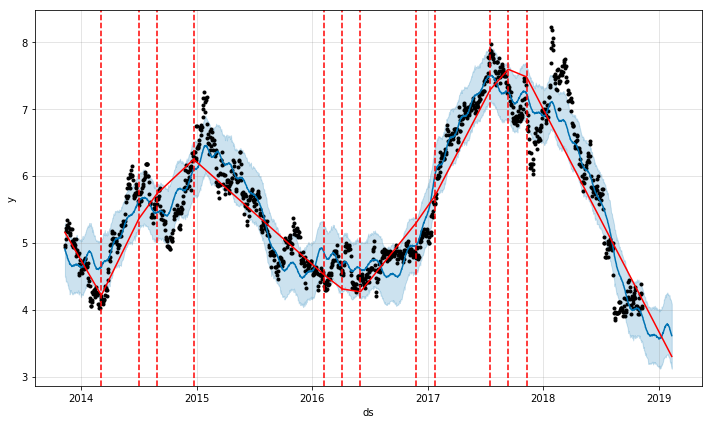

In [13]:
# Plot using matplotlib inorder to save in notebook
# Red lines are the predicted trend direction changes
chart = model.plot(forecast)
changepoints = add_changepoints_to_plot(chart.gca(), model, forecast)

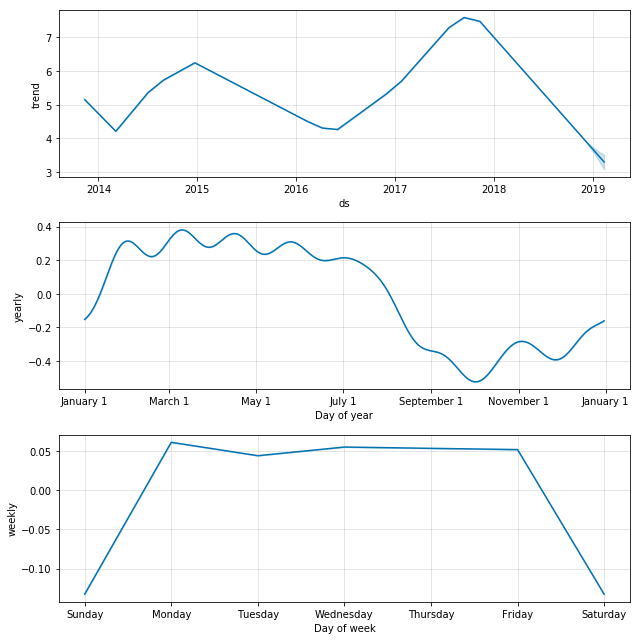

In [14]:
# Insights of trend
components = model.plot_components(forecast)

In [15]:
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:orgDatLen, 'yhat']-symbol_data['y'])**2)) )

RMSE: 0.320048


In [16]:
for hada_kodu, hata_deger in calculate_prediction_error(forecast,(forecast.shape[0]-orgDatLen)).items():
    print(hada_kodu, hata_deger)

MAPE 3.1104546803249
MAE 0.12584416752925454


In [17]:
# Prepare a cross validation set 66 days rolling with 33 days period
cv = cross_validation(model, horizon = '66 days')

INFO:fbprophet.diagnostics:Making 48 forecasts with cutoffs between 2014-06-06 00:00:00 and 2018-09-04 00:00:00


In [18]:
p = performance_metrics(cv)
p.head()

,horizon,mse,rmse,mae,mape,coverage
1838,7 days,0.157591,0.396978,0.321068,0.058032,0.391111
192,7 days,0.156866,0.396063,0.320050,0.057922,0.391111
427,7 days,0.158308,0.397879,0.321470,0.058125,0.391111
1413,7 days,0.159258,0.399072,0.322593,0.058236,0.391111
97,7 days,0.159470,0.399337,0.322893,0.058362,0.391111


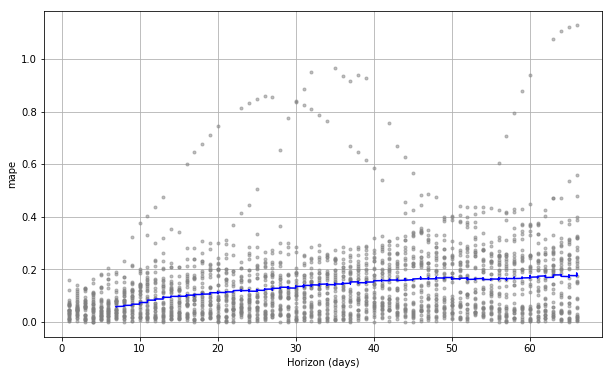

In [19]:
# Plot mean absolute percentage error graph over time
fig = plot_cross_validation_metric(cv, metric='mape')

In [20]:
forward_lookup = forecast.loc[orgDatLen+1:orgDatLen+3][['ds','y','yhat','trend']]
forward_lookup['yhat'] = forward_lookup['yhat']
forward_lookup['ds'] = forward_lookup['ds'].astype(str)

In [21]:
print("{0} prediction: %{1:,.4f}".format((forward_lookup['ds'].values[1])
                                      ,forward_lookup['yhat'].pct_change().values[1]*100))
print("{0} prediction: %{1:,.4f}".format((forward_lookup['ds'].values[2])
                                      ,forward_lookup['yhat'].pct_change().values[2]*100))

2018-11-12 prediction: %-0.8823
2018-11-13 prediction: %-0.8431


In [22]:
forward_lookup[['ds','y','trend']]

,ds,y,trend
1304,2018-11-09,4.03,4.156277
1305,2018-11-12,NaN,4.129004
1306,2018-11-13,NaN,4.119913
